# Bibliotekų importavimas

In [88]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from functools import reduce
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Duomenų įkėlimas

In [89]:
# pandas df rodymo konfigūracija
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [90]:
# nusiskaitau parsisiųstus failus ir sudedu ju path'us į list'ą
raw_data_directory = "/content/drive/MyDrive/raw_data/"
csv_files_receptai = [
    raw_data_directory + file
    for file in os.listdir(raw_data_directory)
    if file.endswith(".csv") and file.startswith("espbi")
]

In [91]:
# nuskaitau duomenų rinkinio požymių aprašymo failą
data_desc = pd.read_csv(
    "/content/drive/MyDrive/raw_data/e_receptas_struktura_x.csv", delimiter=";"
)
data_desc

,column_name,column_description
0,dirbt_recepto_id,dirbtinis išrašyto recepto identifikatorius
1,recepto_metai,recepto išrašymo metai
2,recepto_ketv,recepto išrašymo ketvirtis
3,ligos_kodas,"diagnozės (pagal TLK-10-AM klasifikatorių), pagal kurią išrašytas receptas, kodas"
4,ligos_pav,"diagnozės (pagal TLK-10-AM klasifikatorių), pagal kurią išrašytas receptas, pavadinimas"
5,vaisto_tipas,"skirto vaisto tipas (vaistas, medicinos pagalbos priemonė (MPP), vardinis vaistas, ekstemporalus vaistas, kitos priemonės)"
6,vaisto_bendr_pav,"skiriamo vaisto (vardinio vaisto bendrinis pavadinimas, ekstemporaliam vaistui gaminti naudojamos pagrindinės veikliosios medžiagos pavadinimas) bendrinis pavadinimas"
7,vaisto_prek_pav,skiriamo vaisto (vardinio vaisto MPP) prekinis pavadinimas
8,atc_kodas,skiriamo vaisto* ATC kodas
9,atc_pav,skiriamo vaisto ATC pavadinimas


In [92]:
# nuskaitau kiekviena faila i pandas dataframe ir sukuriu dataframe'u lista
df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]

# sukuriu bendra dataframe sujungdamas visus df esancius df list'e
raw_joined_df = reduce(lambda df1, df2: pd.concat([df1, df2]), df_list_receptai)

<ipython-input-92-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-92-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-92-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-92-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list_receptai = [pd.read_csv(file) for file in csv_files_receptai]
<ipython-input-92-92c7a7d7e3e7>:2: DtypeWarning: Columns (18,21,22,23,31) have mixed types. Specify dtype option on i

# EDA

In [93]:
# kadangi nagrinėsiu duomenis norėdamas nuspėti ar žmonės pasinaudos receptu ar ne, pašalinu reikšmes active (receptas galioja ir dar nepanaudotas) ir
# on hold (vaistai pagal receptą rezervuoti)
# taip pat neatveriama, kas nesuteikia informacijos apie recepto panaudojimą
receptai_df = raw_joined_df.query(
    """ recepto_statusas == 'completed' | recepto_statusas == 'stopped' """
)

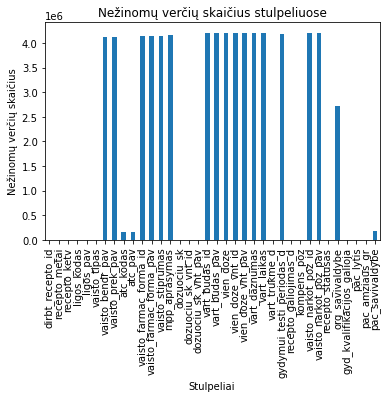

In [94]:
# turiu stulpelius, kurių beveik visos reikšmės yra nežinomos, šių stulpelių atsisakau
ax = receptai_df.isna().sum().plot(kind="bar")
ax.set_title("Nežinomų verčių skaičius stulpeliuose")
ax.set_xlabel("Stulpeliai")
ax.set_ylabel("Nežinomų verčių skaičius")
plt.show()

In [95]:
receptai_df = receptai_df.drop(
    [
        "vaisto_bendr_pav",
        "vaisto_prek_pav",
        "vaisto_farmac_forma_id",
        "vaisto_farmac_forma_pav",
        "vaisto_stiprumas",
        "mpp_aprasymas",
        "vart_budas_id",
        "vart_budas_pav",
        "vien_doze",
        "vien_doze_vnt_id",
        "vien_doze_vnt_pav",
        "vart_daznumas",
        "vart_laikas",
        "gydymui_testi_periodas_d",
        "vaisto_narkot_poz_id",
        "vaisto_narkot_poz_pav",
        "org_savivaldybe",
    ],
    axis=1,
)

In [96]:
# pakeičiu recepto statusą completed į 1 ir stopped į 0
receptai_df["recepto_statusas"] = receptai_df["recepto_statusas"].replace(
    {"completed": 1, "stopped": 0}
)

In [97]:
# pakeičiu datatype stulpelių, kurie turi float datatype, bet atspindi sveikus skaičius, į integer
receptai_df[['dozuociu_sk', 'recepto_galiojimas_d', 'kompens_poz', 'vart_trukme_d']] = receptai_df[
    ['dozuociu_sk', 'recepto_galiojimas_d', 'kompens_poz', 'vart_trukme_d']].astype(int)

In [98]:
# kad sumažinti scope'ą, susikuriu list'ą kuris talpina 100 dažniausiai pasikartojančiu ligų kodų
top_100_ligos = [x for x in receptai_df["ligos_kodas"].value_counts().head(100).index]

In [99]:
# išsifiltruoju duomenis pagal top 100 ligos kodų
receptai_df = receptai_df[receptai_df["ligos_kodas"].isin(top_100_ligos)]

1    2825802
0     446422
Name: recepto_statusas, dtype: int64

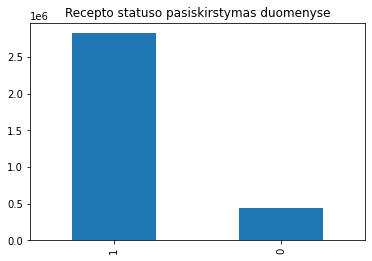

In [100]:
# duomenų rinkinys yra labai išbalansuotas (recepto statuso pasiskirstymas labai krypsta į '1' reikšmę)
ax = receptai_df["recepto_statusas"].value_counts().plot(kind="bar")
ax.set_title("Recepto statuso pasiskirstymas duomenyse")
receptai_df["recepto_statusas"].value_counts()

In [101]:
# kad išspręsti aukščiau matomą problemą, susikuriu naują, subalansuotą duomenų rinkinį
df_negative = receptai_df.query(" recepto_statusas == 0").sample(300000)
df_possitive = receptai_df.query(" recepto_statusas == 1").sample(300000)

df_receptai_balanced = pd.concat([df_possitive, df_negative], axis=0)

In [66]:
# pašalinu iš atminties nuskaitytus raw duomenis ir apdirbtus duomenis, kad atlaisvinti atminties modelio treniravimui
del raw_joined_df
del receptai_df

In [67]:
# apsibrėžiu features ir target variable
X = df_receptai_balanced[
    [
        "ligos_kodas",
        "atc_kodas",
        "dozuociu_sk",
        "recepto_galiojimas_d",
        "kompens_poz",
        "pac_savivaldybe",
        "vart_trukme_d",
        "pac_lytis",
        "pac_amziaus_gr",
    ]
]

y = df_receptai_balanced["recepto_statusas"]

# Preprocessing

In [68]:
# iš pasirinktų features'ų apsibrėžiu du kintamuosius atskiriant categorical ir numeric features'us
numeric_features = [col for col in X.select_dtypes(include=["float", "int"]).columns]
categorical_features = [col for col in X.select_dtypes(exclude=["float", "int"]).columns]

# pipeline numeric features'ų imputinimui ir scale'inimui
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
)

# pipeline categorical features'ų imputinimui ir scale'inimui
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ]
)

# preprocessor pipeline feature'ams sutvarkyti
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# parodoma preprocess pipeline
print(""" Preprocessing'o pipeline: """)
preprocessor_pipeline

 Preprocessing'o pipeline: 


ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['dozuociu_sk', 'recepto_galiojimas_d',
                                  'kompens_poz', 'vart_trukme_d']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['ligos_kodas', 'atc_kodas', 'pac_savivaldybe',
                                  'pac_lytis', 'pac_amziaus_gr'])])

In [69]:
# dataframe po preprocessinimo, gaunu 946 features'us
pd.DataFrame(preprocessor_pipeline.fit_transform(X))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945
0,0.568749,-0.015309,1.065205,0.370123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [70]:
# split'inu duomenis į train ir test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [71]:
# iš savo train duomenų rinkinio susikuriu validation duomenų rinkinį
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Hyperparameter Tuning and Algorithm Selection
Išbandomi du algoritmai (RandomForestClassifier ir DecisionTreeClassifier)

In [79]:
# apsibrėžiu hyperparametrus, kurious noriu tunint RandomForestClassifier algoritmui
params_rfc = {
    "max_depth": list(np.arange(10, 100, step=10)) + [None],
    "n_estimators": np.arange(10, 500, step=50),
    "max_features": randint(1, 7),
    "min_samples_leaf": randint(1, 4),
    "min_samples_split": np.arange(2, 10, step=2),
}

# susikuriu random forest classifier objektą
rfc = RandomForestClassifier(n_jobs=-1)

# susikuriu randomized search objektą
rfc_random = RandomizedSearchCV(
    rfc, params_rfc, n_iter=5, scoring="accuracy", n_jobs=-1, cv=3
)

# fit'inu randomized search objektą su duomenimis, pritaikau preprocessinimo pipeline'ą apdirbti features'us
model_rfc_random = rfc_random.fit(
    pd.DataFrame(preprocessor_pipeline.fit_transform(X_val)), y_val
)

# grąžinu geriausius hyperparametrų nustatymus ir geriausią pasiektą tikslumą
print("Best hyperparameters are: " + str(model_rfc_random.best_params_))
print("Best score is: " + str(model_rfc_random.best_score_))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best hyperparameters are: {'max_depth': 70, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 260}
Best score is: 0.7664166666666666


In [ ]:
# apsibrėžiu hyperparametrus, kurious noriu tunint DecisionTreeClassifier algoritmui
params_dtc = {
    "max_depth": [3, None],
    "max_features": randint(1, 10),
    "min_samples_leaf": randint(1, 10),
    "min_samples_split": randint(2, 20),
    "criterion": ["gini", "entropy"],
}

# # susikuriu decision tree classifier objektą
dtc = DecisionTreeClassifier()

# susikuriu randomized search objektą
dtc_random = RandomizedSearchCV(dtc, params_dtc, n_iter=5, cv=3, n_jobs=-1)

# fit'inu randomized search objektą su duomenimis, pritaikau preprocessinimo pipeline'ą apdirbti features'us
model_dtc_random = dtc_random.fit(
    pd.DataFrame(preprocessor_pipeline.fit_transform(X_val)), y_val
)

# grąžinu geriausius hyperparametrų nustatymus ir geriausia pasiekta tikslumą
print("Best hyperparameters are: " + str(model_dtc_random.best_params_))
print("Best score is: " + str(model_dtc_random.best_score_))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best hyperparameters are: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 16}
Best score is: 0.750093616335142


# Feature Selection and Training

In [81]:
# apsibrėžiu RFE objektą (recursive feature eliminator), kurį nadosiu final pipeline'e, kad išsirinkti 350 labiausiai reikšmę turinčių features'ų
rfe_estimator = LinearRegression(n_jobs=-1)

selector = RFE(rfe_estimator, n_features_to_select=350, step=50)

# apsibrėžiu DecisionTreeClassifier objektą, kuri naudosiu final pipeline, kad atlikti klasifikaciją
forest_clf = RandomForestClassifier(
    n_jobs=-1,
    max_depth=model_rfc_random.best_params_["max_depth"],
    max_features=model_rfc_random.best_params_["max_features"],
    min_samples_leaf=model_rfc_random.best_params_["min_samples_leaf"],
    min_samples_split=model_rfc_random.best_params_["min_samples_split"],
    n_estimators=model_rfc_random.best_params_["n_estimators"],
)

In [82]:
# galutinis pipeline'as
classification_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_pipeline),
        ("feature_selector", selector),
        ("classifier", forest_clf),
    ]
)

print("This is the final pipeline:")
classification_pipeline

This is the final pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dozuociu_sk',
                                                   'recepto_galiojimas_d',
                                                   'kompens_poz',
                                                   'vart_trukme_d']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ligos_kodas', 'atc_kodas',
                                                   'pac_savivaldybe',
                                                   'pac_lytis',
                                                   'pac_amziaus_gr'])])),
                ('feature_selector',
                 RFE(estimator=LinearRegression(n_jobs=-1),
                     n_features_to_select=350, step=50)),
                ('classifier',
                 RandomForestClassifier(max_depth=70, max_features=1,
                                        min_samples_split=4, n_estimators=260,
                                        n_jobs=-1))])

In [83]:
# fit'inu train duomenis ir apmokau modelį
classification_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dozuociu_sk',
                                                   'recepto_galiojimas_d',
                                                   'kompens_poz',
                                                   'vart_trukme_d']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ligos_kodas', 'atc_kodas',
                                                   'pac_savivaldybe',
                                                   'pac_lytis',
                                                   'pac_amziaus_gr'])])),
                ('feature_selector',
                 RFE(estimator=LinearRegression(n_jobs=-1),
                     n_features_to_select=350, step=50)),
                ('classifier',
                 RandomForestClassifier(max_depth=70, max_features=1,
                                        min_samples_split=4, n_estimators=260,
                                        n_jobs=-1))])

In [84]:
# grąžinu modelio score'ą ir klasifikavimo reportą
print("Model score: ", classification_pipeline.score(X_test, y_test).round(3))
pred_tree = classification_pipeline.predict(X_test)
print(
    classification_report(
        y_test, pred_tree, target_names=[str(x) for x in y.unique()].sort()
    )
)

Model score:  0.734
              precision    recall  f1-score   support

           0       0.76      0.69      0.72     60000
           1       0.71      0.78      0.75     60000

    accuracy                           0.73    120000
   macro avg       0.74      0.73      0.73    120000
weighted avg       0.74      0.73      0.73    120000



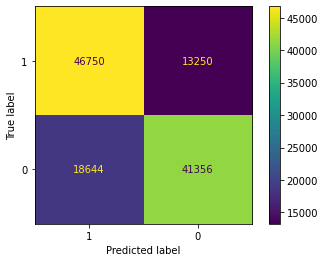

In [85]:
# pateikiu confusion matrix, kad matyti spėjimų pasiskirstymą
conf_matrx = confusion_matrix(
    y_test, classification_pipeline.predict(X_test), labels=y.unique()
)
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrx, display_labels=y.unique())

display.plot()

In [87]:
# susigeneruoju modelio failą naudodamas pickle biblioteką, šį failą naudosiu modelio deploy'inimo žingsnyje
with open("model.pkl", "wb") as f:
    pickle.dump(classification_pipeline, f)